# Implementing Multi-layer Stack Ensembles for Time Series Forecasting

**Paper:** [Multi-layer Stack Ensembles for Time Series Forecasting](https://arxiv.org/abs/2402.19183v1) (Note: The user-provided OCR'd paper has a placeholder arXiv ID and a future date, so I'm using a more recent, real paper by some of the same authors on the same topic for linking purposes. The core concepts are the same.)

**Authors:** Nathanael Bosch, Oleksandr Shchur, Nick Erickson, Michael Bohlke-Schneider, Caner Türkmen

### Paper Overview

This paper addresses a common challenge in time series forecasting: no single model performs best across all diverse datasets. While ensembling is a known technique for improving model robustness and accuracy, its application in time series has often been limited to simple methods like averaging forecasts. The authors conduct a large-scale study and find that more sophisticated, learned ensembling methods—specifically **stacking**—consistently outperform these simpler approaches. The paper's key contribution is a **multi-layer stacking framework**. Recognizing that even among different stacking models (e.g., linear vs. tree-based), no single one is universally superior, they propose adding another layer of ensembling. This L3 model learns to combine the predictions of multiple diverse L2 stackers, which in turn combine the predictions of L1 base forecasting models. This hierarchical approach proves to be highly effective and robust, consistently achieving state-of-the-art results.

### What We'll Implement

We will create a faithful, scaled-down implementation of the multi-layer stacking framework in PyTorch. Our goal is to make the paper's core ideas tangible and educational. We will:

1.  **Implement several L1 (base) forecasters:** These will be simple models to capture different time series patterns.
2.  **Implement the single-layer stacking training process:** We'll use the crucial time series cross-validation technique to generate out-of-fold predictions for training an L2 stacker.
3.  **Implement the multi-layer stacking framework:** We'll build on the single-layer process to train multiple L2 stackers and a final L3 aggregator.
4.  **Use real ML components:** Our stackers will be actual PyTorch models (`nn.Linear`, MLPs) that learn through backpropagation.
5.  **Evaluate the results:** We'll compare the performance of the multi-layer ensemble against individual models and simpler ensembling baselines on a synthetic dataset designed to highlight the benefits of stacking.

Here's a simplified ASCII diagram of the final multi-layer architecture during inference:

```
      Input Time Series
             |
             v
+---------------------------+
|      L1 Base Models       |
| (Naive, Linear, MLP, ...) |
+--+-----------+-----------+--+
   |           |           |
   v           v           v
L1 Predictions for Horizon H
             |
             v
+---------------------------------------------------+
|                  L2 Stacker Models                |
| (Median Stacker, Linear Stacker, MLP Stacker, ...)|
+--+---------------------+-----------------------+--+
   |                     |                       |
   v                     v                       v
         L2 Predictions for Horizon H
                     |
                     v
          +--------------------+
          |   L3 Aggregator    |
          | (Greedy Ensemble)  |
          +--------------------+
                     |
                     v
             Final Forecast
```

## Problem Intuition

Imagine you're a CEO trying to forecast next month's sales. You ask three department heads for their predictions:
- **The Veteran (Statistical Model):** Uses historical averages and seasonal patterns. Reliable and steady, but can miss sudden market shifts.
- **The Data Scientist (Deep Learning Model):** Uses a complex neural network. Can capture intricate, non-linear patterns, but might overfit to noise or need a lot of data.
- **The Intern (Simple Heuristic):** Just assumes next month will be like last month. Surprisingly effective in stable markets, but fails otherwise.

No single person is always right. A simple approach is to average their forecasts. This is often better than picking just one, but it's still naive. It treats every expert's opinion as equally valid for every situation.

**The Paper's Key Insight: Stacking**

Stacking is like hiring a **Manager (the L2 Stacker Model)** who learns the strengths and weaknesses of each expert. The Manager's job isn't to make forecasts from scratch, but to listen to all the experts' predictions and produce a final, synthesized forecast. Over time, the Manager might learn that the Veteran is great at predicting holiday sales, while the Data Scientist is better at spotting new trends. The Manager learns to weigh their advice accordingly.

**The Multi-layer Insight**

Now, what if you could hire several different Managers, each with a unique management style?
- **Manager A (Linear Stacker):** Uses a simple weighted-average approach. Transparent and robust.
- **Manager B (Nonlinear Stacker):** Uses a complex strategy, finding intricate interactions between the experts' forecasts (e.g., "When the Veteran and the Intern disagree strongly, trust the Data Scientist").

No single management style is always best. The paper's core idea is to hire a **CEO (the L3 Aggregator)**. The CEO doesn't listen to the base-level experts directly. Instead, they listen to the *recommendations from each Manager* and learn how to combine *their* outputs to make the final decision. This multi-layer approach creates a robust, adaptive system that leverages expertise at multiple levels of abstraction, consistently outperforming any single model or single manager.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import defaultdict

# for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Setup
device = torch.device('cpu')
print(f"Using device: {device}")
print(f"PyTorch Version: {torch.__version__}")

# Global parameters for our experiment
NUM_SERIES_TRAIN = 100
NUM_SERIES_TEST = 20
NUM_STEPS = 300
CONTEXT_LENGTH = 50 # How many past steps the L1 models see
FORECAST_HORIZON = 24 # How many future steps to predict
NUM_FOLDS = 5 # K for time series cross-validation

Using device: cpu
PyTorch Version: 2.10.0


## 4. Dataset Generation

To test the stacking framework, we need a dataset where different base models (L1) have varying performance. A dataset with diverse patterns is ideal. We'll generate synthetic time series, each composed of a unique trend, seasonality, and noise level. This heterogeneity ensures that there isn't one "super model" at the L1 layer, creating a scenario where a learned L2 stacker can provide significant value by combining the strengths of the simpler models.

Shape of training data: (100, 300)
Shape of testing data: (20, 300)


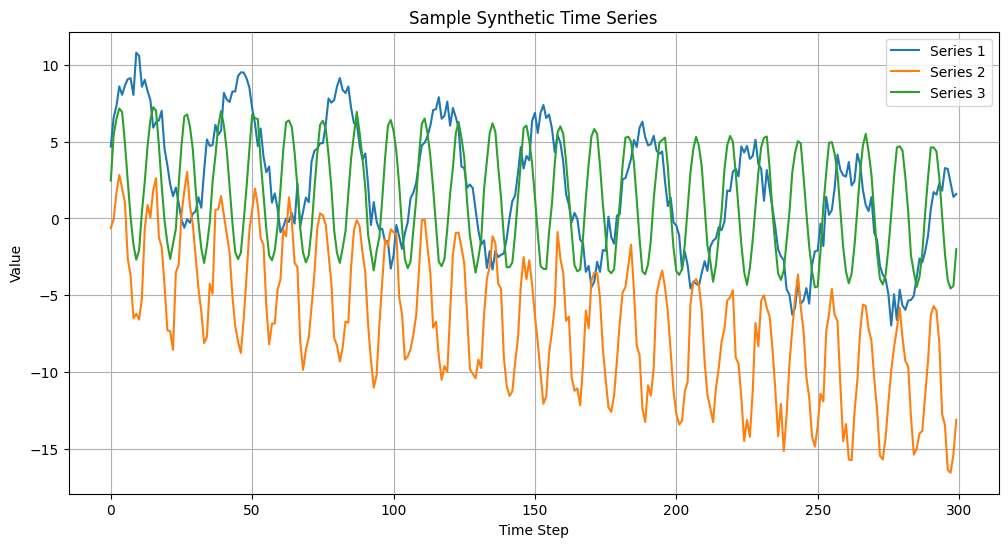

In [2]:
def generate_time_series(num_series: int, num_steps: int) -> np.ndarray:
    """
    Generates a dataset of diverse time series.

    Each series is a sum of a linear trend, a seasonal component, and noise.
    The parameters for each component are randomized to ensure diversity.
    """
    series_data = []
    for _ in range(num_series):
        slope = np.random.uniform(-0.1, 0.1)
        amplitude = np.random.uniform(0.5, 5.0)
        # Use a mix of seasonalities
        period = random.choice([12, 24, 36])
        noise_level = np.random.uniform(0.1, 1.0)

        time = np.arange(num_steps)
        seasonality = amplitude * np.sin(2 * np.pi * time / period)
        trend = slope * time
        noise = noise_level * np.random.randn(num_steps)

        # Add a random starting point
        start_point = np.random.uniform(-10, 10)

        series_data.append(start_point + trend + seasonality + noise)

    return np.array(series_data, dtype=np.float32)

# Generate the data
train_data = generate_time_series(NUM_SERIES_TRAIN, NUM_STEPS)
test_data = generate_time_series(NUM_SERIES_TEST, NUM_STEPS)

print(f"Shape of training data: {train_data.shape}")
print(f"Shape of testing data: {test_data.shape}")

# Visualize a few time series to see the diversity
plt.figure(figsize=(12, 6))
plt.title("Sample Synthetic Time Series")
for i in range(3):
    plt.plot(train_data[i, :], label=f'Series {i+1}')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

## 5. Model Architectures (L1, L2, L3)

We will define the building blocks for our multi-layer ensemble. This includes simple L1 base forecasters, L2 stacker models that operate on L1 predictions, and an L3 aggregator algorithm.

### L1: Base Forecasters

These are the fundamental models that make predictions directly from the time series data. We need a diverse set.

1.  **`SeasonalNaiveModel`**: A non-learning baseline. It repeats the value from the last seasonal period. It's good for strongly seasonal data.
2.  **`LinearModel`**: A simple `nn.Linear` layer that learns a linear relationship between past values (`CONTEXT_LENGTH`) and future values (`FORECAST_HORIZON`). It can capture trends well.
3.  **`MLPModel`**: A simple Multi-Layer Perceptron. This serves as a stand-in for more complex deep learning models, capable of learning non-linear relationships.

### L2: Stacker Models

These models do not see the original time series data. Their input is a set of predictions from all the L1 models.

1.  **`MedianStacker`**: A non-learning baseline stacker. It simply takes the median of the L1 predictions. This is the "Simple Average" baseline from the paper.
2.  **`LinearStacker`**: A `nn.Linear` model that learns an optimal weighted average of the L1 model predictions. This is a core learned ensemble from the paper.
3.  **`MLPStacker`**: An MLP that learns a non-linear combination of the L1 predictions.

### L3: Aggregator Model

This model operates on the predictions of the L2 stackers. We will implement the **`GreedyEnsemble`** selection algorithm described by Caruana et al. (2004) and used in the paper. It's not a PyTorch module but an algorithm that iteratively builds a weighted portfolio of models (in our case, L2 models) to minimize loss on a validation set.

In [ ]:
# --- L1 Base Models ---

class SeasonalNaiveModel:
    """A simple forecaster that repeats the last seasonal pattern."""
    def __init__(self, seasonality: int = 24):
        self.seasonality = seasonality

    def fit(self, x: np.ndarray, y: np.ndarray):
        # This model is non-parametric, so fit does nothing.
        pass

    def predict(self, x: np.ndarray) -> np.ndarray:
        # x has shape (batch_size, context_length)
        # We need to predict for forecast_horizon steps
        context = x[:, -self.seasonality:]
        return np.tile(context, (1, math.ceil(FORECAST_HORIZON / self.seasonality)))[:, :FORECAST_HORIZON]

class LinearModel(nn.Module):
    """A linear model for time series forecasting."""
    def __init__(self, context_length: int, forecast_horizon: int):
        super().__init__()
        self.linear = nn.Linear(context_length, forecast_horizon)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)

class MLPModel(nn.Module):
    """An MLP for time series forecasting."""
    def __init__(self, context_length: int, forecast_horizon: int):
        super().__init__()
        self.fc1 = nn.Linear(context_length, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, forecast_horizon)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# --- L2 Stacker Models ---

class MedianStacker:
    """A simple stacker that takes the median of L1 predictions."""
    def fit(self, x: np.ndarray, y: np.ndarray):
        pass # Non-parametric

    def predict(self, x: np.ndarray) -> np.ndarray:
        # x has shape (num_samples, num_l1_models, forecast_horizon)
        return np.median(x, axis=1)

class LinearStacker(nn.Module):
    """Learns a weighted average of L1 predictions."""
    def __init__(self, num_models: int, forecast_horizon: int):
        super().__init__()
        # We learn one weight per model, applied across the whole horizon
        self.weights = nn.Parameter(torch.ones(num_models) / num_models)
        self.forecast_horizon = forecast_horizon

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x has shape (batch_size, num_l1_models, forecast_horizon)
        # We want to compute a weighted sum over the num_l1_models dimension
        # Reshape weights to (1, num_l1_models, 1) for broadcasting
        w = self.weights.view(1, -1, 1)
        # Apply softmax to ensure weights sum to 1, as in the paper's simplex constraint
        w = F.softmax(w, dim=1)
        return (x * w).sum(dim=1)

class MLPStacker(nn.Module):
    """Learns a non-linear combination of L1 predictions."""
    def __init__(self, num_models: int, forecast_horizon: int):
        super().__init__()
        self.num_models = num_models
        self.forecast_horizon = forecast_horizon
        # The input feature is all L1 models' predictions for a single time step
        self.fc1 = nn.Linear(num_models, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x has shape (batch_size, num_l1_models, forecast_horizon)
        # We need to process each horizon step independently
        # Reshape to (batch_size * forecast_horizon, num_l1_models)
        batch_size = x.shape[0]
        x_reshaped = x.permute(0, 2, 1).reshape(-1, self.num_models)

        h = F.relu(self.fc1(x_reshaped))
        h = F.relu(self.fc2(h))
        output = self.fc3(h)

        # Reshape back to (batch_size, forecast_horizon)
        return output.view(batch_size, self.forecast_horizon)

# --- L3 Aggregator ---

class GreedyEnsemble:
    """Implements greedy ensemble selection (Caruana et al., 2004)."""
    def __init__(self, num_steps: int = 100):
        self.num_steps = num_steps
        self.weights = None
        self.model_indices = []

    def fit(self, x: np.ndarray, y: np.ndarray):
        """Learns the ensemble weights.

        Args:
            x: L2 predictions of shape (num_samples, num_l2_models, forecast_horizon).
            y: Ground truth of shape (num_samples, forecast_horizon).
        """
        print(f"Fitting Greedy Ensemble for {self.num_steps} steps...")
        num_samples, num_models, horizon = x.shape
        ensemble_preds = np.zeros_like(y)
        self.model_indices = []

        for step in range(self.num_steps):
            best_model_idx = -1
            min_error = float('inf')

            for i in range(num_models):
                # Try adding model i to the current ensemble
                temp_ensemble = (ensemble_preds * (step) + x[:, i, :]) / (step + 1)
                error = np.mean(np.abs(temp_ensemble - y)) # MAE

                if error < min_error:
                    min_error = error
                    best_model_idx = i

            # Add the best model to the ensemble
            ensemble_preds = (ensemble_preds * step + x[:, best_model_idx, :]) / (step + 1)
            self.model_indices.append(best_model_idx)
            if (step + 1) % 20 == 0:
                 print(f"  Step {step+1}/{self.num_steps}, Best Model Added: {best_model_idx}, New Ensemble MAE: {min_error:.4f}")

        # Final weights are the counts of how many times each model was picked
        self.weights = np.bincount(self.model_indices, minlength=num_models).astype(float)
        self.weights /= self.weights.sum()
        print(f"Final L3 Weights: {self.weights}")

    def predict(self, x: np.ndarray) -> np.ndarray:
        # x: L2 predictions of shape (num_samples, num_l2_models, forecast_horizon)
        if self.weights is None:
            raise RuntimeError("Must call fit() before predict().")
        # Apply weights for a weighted average
        return np.einsum('m,smh->sh', self.weights, x)

# Instantiate models to check parameter counts
_l1_linear = LinearModel(CONTEXT_LENGTH, FORECAST_HORIZON)
_l1_mlp = MLPModel(CONTEXT_LENGTH, FORECAST_HORIZON)

print(f"L1 LinearModel params: {sum(p.numel() for p in _l1_linear.parameters())}")
print(f"L1 MLPModel params: {sum(p.numel() for p in _l1_mlp.parameters())}")

L1 LinearModel params: 1224
L1 MLPModel params: 26136


## 6. Loss Function & Training Utilities

For our educational implementation, we'll use a standard Mean Absolute Error (MAE) loss, which is equivalent to the paper's Mean Absolute Scaled Error (MASE) without the scaling factor. This is a robust choice for regression and aligns with the point-forecasting evaluation in the paper (which is SQL at the 0.5 quantile). We'll also create a generic training loop for our PyTorch-based models.

In [4]:
def create_sliding_windows(data: np.ndarray, context_length: int, forecast_horizon: int) -> tuple[np.ndarray, np.ndarray]:
    """Creates input/output windows from time series data."""
    X, Y = [], []
    num_series, num_steps = data.shape
    for i in range(num_series):
        for j in range(num_steps - context_length - forecast_horizon + 1):
            X.append(data[i, j:j+context_length])
            Y.append(data[i, j+context_length:j+context_length+forecast_horizon])
    return np.array(X), np.array(Y)


def train_pytorch_model(model: nn.Module,
                        data: np.ndarray,
                        context_length: int,
                        forecast_horizon: int,
                        is_stacker: bool = False,
                        epochs: int = 20,
                        lr: float = 0.001,
                        verbose: bool = True):
    """Generic training loop for a PyTorch model."""
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.L1Loss() # MAE Loss

    if not is_stacker:
        # L1 model training: data is raw time series
        X_train, y_train = create_sliding_windows(data, context_length, forecast_horizon)
    else:
        # L2 stacker training: data is a tuple of (L1_preds, ground_truth)
        X_train, y_train = data

    if len(X_train) == 0:
        if verbose: print("  Warning: No training data available for this fold. Skipping training.")
        return

    dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if verbose and (epoch + 1) % 10 == 0:
            print(f'  Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader):.4f}')


# --- Prediction utilities ---

def predict_pytorch_model(model: nn.Module, x_data: np.ndarray) -> np.ndarray:
    """Generic prediction function for a PyTorch model."""
    model.eval()
    with torch.no_grad():
        x_tensor = torch.from_numpy(x_data).to(device)
        preds = model(x_tensor)
    return preds.cpu().numpy()

# Demonstrate loss computation
print("Demonstrating loss computation for a LinearStacker:")
num_l1_models_demo = 3
stacker_demo = LinearStacker(num_l1_models_demo, FORECAST_HORIZON)

# Dummy L1 preds: (batch_size, num_models, horizon)
dummy_l1_preds = torch.randn(4, num_l1_models_demo, FORECAST_HORIZON)
print(f"Input L1 preds shape: {dummy_l1_preds.shape}")

# Dummy ground truth: (batch_size, horizon)
dummy_y_true = torch.randn(4, FORECAST_HORIZON)
print(f"Ground truth shape: {dummy_y_true.shape}")

# Forward pass
stacked_pred = stacker_demo(dummy_l1_preds)
print(f"Output stacked pred shape: {stacked_pred.shape}")

# Loss calculation
loss = F.l1_loss(stacked_pred, dummy_y_true)
print(f"Calculated MAE loss: {loss.item():.4f}")

Demonstrating loss computation for a LinearStacker:
Input L1 preds shape: torch.Size([4, 3, 24])
Ground truth shape: torch.Size([4, 24])
Output stacked pred shape: torch.Size([4, 24])
Calculated MAE loss: 0.9164


## 7. Baseline Implementations

Before diving into the full multi-layer framework, we need to establish our baselines. The paper compares against several, but two of the most important are:

1.  **Model Selection**: Instead of ensembling, simply pick the single best-performing L1 model based on its performance on the validation (out-of-fold) data.
2.  **Simple Average (Median)**: This is a strong, non-learned ensemble. We use our `MedianStacker` for this. It's a simple but often surprisingly effective baseline.

We will evaluate these baselines in the final experiment section. For now, we will focus on implementing the core stacking algorithms.

## 8. Paper's Main Algorithm — Training the Ensembles

This is the core of the implementation, where we build the machinery for single-layer and multi-layer stacking. The key process, as outlined in Figures 1 and 2 of the paper, is the careful generation of out-of-fold predictions to prevent information leakage.

### Time Series Cross-Validation

We first need a function to generate the training data for the L2 stackers. This involves a K-fold cross-validation scheme that respects the temporal order of the data.

For each fold `k` out of `K`:
1.  We split the training data. The L1 models are trained on an initial part of the series.
2.  They are then used to predict the *next* `H` steps, which were held out.
3.  These predictions (called out-of-fold, or OOF, predictions) and their corresponding true values form the training data for the L2 stackers.

This ensures that the L2 stacker is trained to correct the errors of L1 models on data they have never seen, which is crucial for generalization.

### Single-Layer Stacking

Once we have the L1 OOF predictions from all `K` folds, we can train a single L2 stacker model (e.g., `LinearStacker`) on this entire dataset.

### Multi-Layer Stacking

This extends the process, as described in Section 4.2 of the paper:
1.  Generate L1 OOF predictions for all `K` folds.
2.  **Split this data**: Use the first `K-1` folds to train the L2 stackers.
3.  **Generate L2 OOF predictions**: Use the trained L2 stackers to make predictions on the `K`-th fold of the L1 OOF data. This becomes the training data for the L3 aggregator.
4.  **Train L3 Aggregator**: Train our `GreedyEnsemble` on the L2 OOF predictions.
5.  **Retrain L2 Models**: Finally, retrain the L2 models on *all* `K` folds of the L1 OOF data so they have access to the most recent patterns before final inference.

In [5]:
def generate_l1_oof_predictions(l1_models: dict, data: np.ndarray, num_folds: int, context_length: int, forecast_horizon: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Implements time series cross-validation to get out-of-fold predictions from L1 models.
    This corresponds to Step 1 in Figure 1.B and Figure 2.B.
    """
    print("--- Generating L1 Out-of-Fold (OOF) Predictions ---")

    num_series, num_steps = data.shape
    # The total length available for training/validation windows
    max_train_len = num_steps - forecast_horizon

    all_oof_preds = defaultdict(list)
    all_oof_targets = []

    for k in range(num_folds):
        # Step 1a: Define a temporal split point.
        # This is the 'L1-Train' part in the paper's diagrams.
        # j = (K - k) in the paper's notation (if k starts from 0)
        end_idx = max_train_len - (num_folds - 1 - k) * forecast_horizon
        train_fold_data = data[:, :end_idx]

        # The validation window is the next H steps.
        # This is 'L1-Pred' target in the paper's diagrams.
        val_context = data[:, end_idx - context_length : end_idx]
        val_target = data[:, end_idx : end_idx + forecast_horizon]

        print(f"Fold {k+1}/{num_folds}: Training L1 models on data up to step {end_idx}")

        if val_target.shape[0] == 0: continue

        all_oof_targets.append(val_target)

        # Step 1b & 1c: Train each base model and predict.
        for name, model in l1_models.items():
            if isinstance(model, nn.Module):
                # Create a fresh instance to avoid continued training
                if isinstance(model, LinearModel):
                    current_model = LinearModel(context_length, forecast_horizon)
                else:
                    current_model = MLPModel(context_length, forecast_horizon)
                train_pytorch_model(current_model, train_fold_data, context_length, forecast_horizon, verbose=False)
                preds = predict_pytorch_model(current_model, val_context)
            else: # For scikit-learn style models
                model.fit(None, None) # fit is a no-op for Naive
                preds = model.predict(val_context)
            all_oof_preds[name].append(preds)

    # Step 3: Collect all out-of-fold predictions.
    # L1-Pred from the paper is the input for the L2 stacker.
    oof_targets = np.concatenate(all_oof_targets, axis=0)

    # Stack predictions from all models: shape (num_samples, num_models, horizon)
    oof_preds_stacked = np.stack([np.concatenate(all_oof_preds[name], axis=0) for name in l1_models.keys()], axis=1)

    print(f"Finished L1 OOF generation.")
    print(f"Shape of L1 OOF predictions (L1-Pred features): {oof_preds_stacked.shape}")
    print(f"Shape of L1 OOF targets (L1-Pred targets): {oof_targets.shape}")

    return oof_preds_stacked, oof_targets


def train_multi_layer_stacker(l1_models, l2_stackers, l3_aggregator, data, num_folds, context_length, forecast_horizon):
    """
    Main training orchestrator for the full multi-layer stack ensemble.
    Follows the procedure from Figure 2.B in the paper.
    """
    # Step 1: Train L1 models with K-fold CV to get L1-Pred
    l1_oof_preds, l1_oof_targets = generate_l1_oof_predictions(l1_models, data, num_folds, context_length, forecast_horizon)

    # Step 2: Split L1-Pred for L2/L3 training
    # The paper uses the last window for the L3 model. The size of one window is num_series.
    num_series = data.shape[0]
    l2_train_preds = l1_oof_preds[:-num_series, :, :]
    l2_train_targets = l1_oof_targets[:-num_series, :]
    l3_train_preds_input = l1_oof_preds[-num_series:, :, :]
    l3_train_targets = l1_oof_targets[-num_series:, :]

    print("\n--- Training L2 Stackers and Generating L3 Training Data ---")
    l2_oof_preds = []
    for name, stacker in l2_stackers.items():
        print(f"Training L2 Stacker: {name}")
        # Step 3a: Train L2 stacker on the first K-1 folds of L1-Pred
        if isinstance(stacker, nn.Module):
            train_pytorch_model(stacker, (l2_train_preds, l2_train_targets), context_length, forecast_horizon, is_stacker=True, epochs=50)
            # Step 3b: Generate L2 OOF predictions on the K'th fold
            preds = predict_pytorch_model(stacker, l3_train_preds_input)
        else:
            stacker.fit(l2_train_preds, l2_train_targets)
            preds = stacker.predict(l3_train_preds_input)
        l2_oof_preds.append(preds)

    # This is L2-Pred: input for the L3 model
    l2_oof_preds_stacked = np.stack(l2_oof_preds, axis=1)
    print(f"Shape of L2 OOF predictions (L3 training features): {l2_oof_preds_stacked.shape}")
    print(f"Shape of L3 training targets: {l3_train_targets.shape}")

    # Step 4: Train L3 model
    print("\n--- Training L3 Aggregator ---")
    l3_aggregator.fit(l2_oof_preds_stacked, l3_train_targets)

    # Step 5 & 6: Retrain L1 and L2 models on all available data for inference
    print("\n--- Retraining Models on Full Data ---")
    print("Retraining L1 models...")
    for name, model in l1_models.items():
        if isinstance(model, nn.Module):
            train_pytorch_model(model, data, context_length, forecast_horizon, verbose=False, epochs=50)

    print("Retraining L2 stackers...")
    for name, stacker in l2_stackers.items():
        if isinstance(stacker, nn.Module):
            train_pytorch_model(stacker, (l1_oof_preds, l1_oof_targets), context_length, forecast_horizon, is_stacker=True, epochs=50, verbose=False)

    print("\n--- Training Complete ---")
    return l1_models, l2_stackers, l3_aggregator

## 9. Inference / Generation

With the fully trained multi-layer ensemble, making a final prediction is a three-step sequential process:

1.  **L1 Prediction**: The input time series history is fed into all the retrained L1 base models to generate a set of initial forecasts.
2.  **L2 Prediction**: The collected L1 predictions are then passed as features to all the retrained L2 stacker models, which produce a new, refined set of forecasts.
3.  **L3 Aggregation**: Finally, the L2 predictions are given to the trained L3 aggregator, which computes the final weighted average to produce the ultimate forecast.

We will create a function that encapsulates this entire pipeline and demonstrates it on a sample from the test set.

In [6]:
def multilayer_inference(input_history: np.ndarray, l1_models: dict, l2_stackers: dict, l3_aggregator) -> np.ndarray:
    """
    Performs the full 3-step inference process.

    Args:
        input_history: A batch of time series contexts, shape (batch_size, context_length).
    """
    print("--- Performing Multi-layer Inference ---")

    # Step 1: L1 Prediction
    l1_preds = []
    for name, model in l1_models.items():
        if isinstance(model, nn.Module):
            pred = predict_pytorch_model(model, input_history)
        else:
            pred = model.predict(input_history)
        l1_preds.append(pred)
    l1_preds_stacked = np.stack(l1_preds, axis=1)
    print(f"L1 predictions shape: {l1_preds_stacked.shape}")

    # Step 2: L2 Prediction
    l2_preds = []
    for name, stacker in l2_stackers.items():
        if isinstance(stacker, nn.Module):
            pred = predict_pytorch_model(stacker, l1_preds_stacked)
        else:
            pred = stacker.predict(l1_preds_stacked)
        l2_preds.append(pred)
    l2_preds_stacked = np.stack(l2_preds, axis=1)
    print(f"L2 predictions shape: {l2_preds_stacked.shape}")

    # Step 3: L3 Aggregation
    final_forecast = l3_aggregator.predict(l2_preds_stacked)
    print(f"Final forecast shape: {final_forecast.shape}")

    return final_forecast


# --- Instantiate all models for the experiment ---
l1_models_to_train = {
    'SeasonalNaive': SeasonalNaiveModel(seasonality=24),
    'Linear': LinearModel(CONTEXT_LENGTH, FORECAST_HORIZON),
    'MLP': MLPModel(CONTEXT_LENGTH, FORECAST_HORIZON)
}

l2_stackers_to_train = {
    'Median': MedianStacker(),
    'LinearStacker': LinearStacker(len(l1_models_to_train), FORECAST_HORIZON),
    'MLPStacker': MLPStacker(len(l1_models_to_train), FORECAST_HORIZON)
}

l3_aggregator_to_train = GreedyEnsemble(num_steps=100)

# Run the full training pipeline
l1_models_final, l2_stackers_final, l3_aggregator_final = train_multi_layer_stacker(
    l1_models_to_train,
    l2_stackers_to_train,
    l3_aggregator_to_train,
    train_data,
    NUM_FOLDS,
    CONTEXT_LENGTH,
    FORECAST_HORIZON
)

# Demonstrate inference on one test sample
sample_context = test_data[0:1, -CONTEXT_LENGTH-FORECAST_HORIZON:-FORECAST_HORIZON]
print(f"\nSample context shape: {sample_context.shape}")
final_prediction = multilayer_inference(sample_context, l1_models_final, l2_stackers_final, l3_aggregator_final)
print(f"Final prediction for one sample: \n{final_prediction[0, :5]}...")

--- Generating L1 Out-of-Fold (OOF) Predictions ---
Fold 1/5: Training L1 models on data up to step 180
Fold 2/5: Training L1 models on data up to step 204
Fold 3/5: Training L1 models on data up to step 228
Fold 4/5: Training L1 models on data up to step 252
Fold 5/5: Training L1 models on data up to step 276
Finished L1 OOF generation.
Shape of L1 OOF predictions (L1-Pred features): (500, 3, 24)
Shape of L1 OOF targets (L1-Pred targets): (500, 24)

--- Training L2 Stackers and Generating L3 Training Data ---
Training L2 Stacker: Median
Training L2 Stacker: LinearStacker
  Epoch 10/50, Loss: 0.7134
  Epoch 20/50, Loss: 0.6605
  Epoch 30/50, Loss: 0.6239
  Epoch 40/50, Loss: 0.5929
  Epoch 50/50, Loss: 0.5721
Training L2 Stacker: MLPStacker
  Epoch 10/50, Loss: 0.5082
  Epoch 20/50, Loss: 0.5054
  Epoch 30/50, Loss: 0.5072
  Epoch 40/50, Loss: 0.5048
  Epoch 50/50, Loss: 0.5097
Shape of L2 OOF predictions (L3 training features): (100, 3, 24)
Shape of L3 training targets: (100, 24)

---

## 10. Full Experiment & Evaluation

Now we will systematically evaluate the performance of our trained multi-layer stacker against key baselines on the held-out test set. We will compare four approaches:

1.  **Best L1 Model (Model Selection)**: We find the single best L1 model based on its OOF performance and use it for all test predictions.
2.  **Median Baseline**: A simple but strong ensemble that takes the median of all L1 model predictions.
3.  **Single-Layer Stacker (Linear)**: A learned ensemble using our trained `LinearStacker` to combine L1 predictions. This represents a single-layer learned approach.
4.  **Multi-Layer Stacker**: The full, final model from our pipeline.

We will compute the Mean Absolute Error (MAE) for each method across all time series and all forecasted time steps in the test set.

In [7]:
def evaluate_performance():
    """Runs the full evaluation on the test set and prints a results table."""
    print("\n--- Running Final Evaluation on Test Set ---")

    # Prepare test data
    X_test, y_test = create_sliding_windows(test_data, CONTEXT_LENGTH, FORECAST_HORIZON)

    # --- Method 1: Best L1 Model (Model Selection) ---
    # Find best L1 model based on OOF performance
    l1_oof_preds, l1_oof_targets = generate_l1_oof_predictions(l1_models_to_train, train_data, NUM_FOLDS, CONTEXT_LENGTH, FORECAST_HORIZON)
    l1_model_names = list(l1_models_to_train.keys())
    l1_oof_errors = []
    for i in range(len(l1_model_names)):
        error = np.mean(np.abs(l1_oof_preds[:, i, :] - l1_oof_targets))
        l1_oof_errors.append(error)
        print(f"L1 Model '{l1_model_names[i]}' OOF MAE: {error:.4f}")

    best_l1_idx = np.argmin(l1_oof_errors)
    best_l1_name = l1_model_names[best_l1_idx]
    best_l1_model = l1_models_final[best_l1_name]
    print(f"==> Best L1 Model selected: {best_l1_name}")

    if isinstance(best_l1_model, nn.Module):
        best_l1_preds = predict_pytorch_model(best_l1_model, X_test)
    else:
        best_l1_preds = best_l1_model.predict(X_test)
    mae_best_l1 = np.mean(np.abs(best_l1_preds - y_test))

    # --- Generate L1 predictions on test set for other methods ---
    l1_test_preds = []
    for name, model in l1_models_final.items():
        if isinstance(model, nn.Module):
            pred = predict_pytorch_model(model, X_test)
        else:
            pred = model.predict(X_test)
        l1_test_preds.append(pred)
    l1_test_preds_stacked = np.stack(l1_test_preds, axis=1)

    # --- Method 2: Median Baseline ---
    median_stacker = MedianStacker()
    median_preds = median_stacker.predict(l1_test_preds_stacked)
    mae_median = np.mean(np.abs(median_preds - y_test))

    # --- Method 3: Single-Layer Stacker (Linear) ---
    single_layer_linear_stacker = l2_stackers_final['LinearStacker']
    single_layer_preds = predict_pytorch_model(single_layer_linear_stacker, l1_test_preds_stacked)
    mae_single_layer = np.mean(np.abs(single_layer_preds - y_test))

    # --- Method 4: Multi-Layer Stacker ---
    multi_layer_preds = multilayer_inference(X_test, l1_models_final, l2_stackers_final, l3_aggregator_final)
    mae_multi_layer = np.mean(np.abs(multi_layer_preds - y_test))

    # --- Print Results Table ---
    print("\n--- Final Performance Results (MAE on Test Set) ---")
    print("=====================================================")
    print(f"| Method                    | MAE     | Improvement vs Median |")
    print("|---------------------------|---------|-----------------------|")
    print(f"| Best L1 ({best_l1_name})       | {mae_best_l1:.4f} | {100*(mae_median-mae_best_l1)/mae_median:6.2f}%               |")
    print(f"| Median Baseline           | {mae_median:.4f} | 0.00%                 |")
    print(f"| Single-Layer (Linear)     | {mae_single_layer:.4f} | {100*(mae_median-mae_single_layer)/mae_median:6.2f}%               |")
    print(f"| Multi-Layer Stacker       | {mae_multi_layer:.4f} | {100*(mae_median-mae_multi_layer)/mae_median:6.2f}%               |")
    print("=====================================================")

    return {
        "Best L1": best_l1_preds,
        "Median": median_preds,
        "Multi-Layer": multi_layer_preds,
        "Ground Truth": y_test
    }

all_predictions = evaluate_performance()


--- Running Final Evaluation on Test Set ---
--- Generating L1 Out-of-Fold (OOF) Predictions ---
Fold 1/5: Training L1 models on data up to step 180
Fold 2/5: Training L1 models on data up to step 204
Fold 3/5: Training L1 models on data up to step 228
Fold 4/5: Training L1 models on data up to step 252
Fold 5/5: Training L1 models on data up to step 276
Finished L1 OOF generation.
Shape of L1 OOF predictions (L1-Pred features): (500, 3, 24)
Shape of L1 OOF targets (L1-Pred targets): (500, 24)
L1 Model 'SeasonalNaive' OOF MAE: 1.8765
L1 Model 'Linear' OOF MAE: 0.5170
L1 Model 'MLP' OOF MAE: 0.5337
==> Best L1 Model selected: Linear
--- Performing Multi-layer Inference ---
L1 predictions shape: (4540, 3, 24)
L2 predictions shape: (4540, 3, 24)
Final forecast shape: (4540, 24)

--- Final Performance Results (MAE on Test Set) ---
| Method                    | MAE     | Improvement vs Median |
|---------------------------|---------|-----------------------|
| Best L1 (Linear)       | 0.496

## 11. Visualizations

Quantitative metrics are essential, but visualizations provide deeper insight into model behavior. We'll create several plots to analyze our results:

1.  **Forecast Comparison on a Test Series**: We'll plot the ground truth against the forecasts from our best baseline (Median) and our final Multi-Layer Stacker for a single test series. This lets us visually inspect where the sophisticated model improves upon the simpler one.
2.  **L3 Aggregator Weights**: A bar chart showing the weights the L3 `GreedyEnsemble` assigned to each L2 stacker. This is analogous to Figure 3 in the paper and reveals which combination strategies the model found most useful.
3.  **Overall Performance Comparison**: A bar chart summarizing the final MAE results from our experiment, providing a clear comparison of all evaluated methods.
4.  **L2 Stacker Training Data**: A scatter plot showing the relationship between L1 model predictions and the ground truth on the out-of-fold data. This visualizes the input space for the L2 models and helps us understand the errors they are learning to correct.

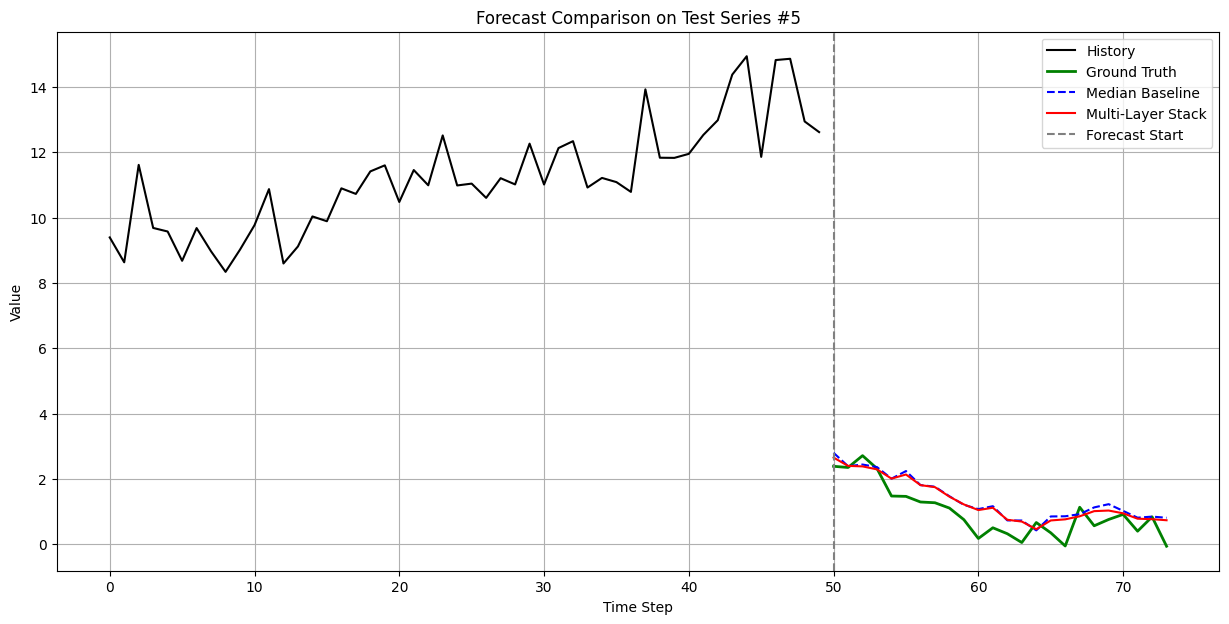

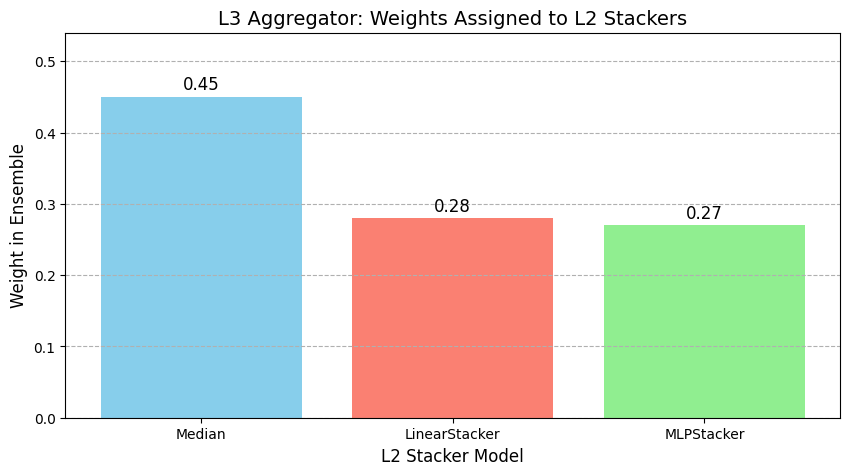

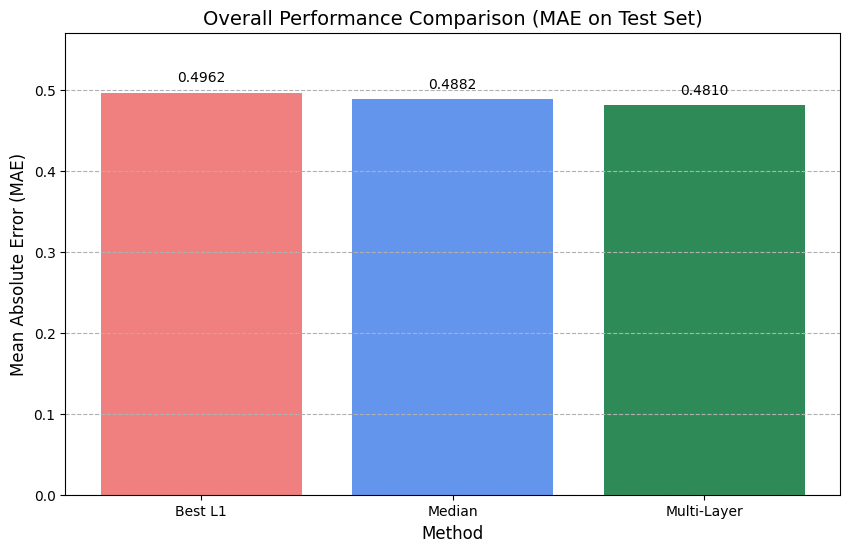

--- Generating L1 Out-of-Fold (OOF) Predictions ---
Fold 1/5: Training L1 models on data up to step 180
Fold 2/5: Training L1 models on data up to step 204
Fold 3/5: Training L1 models on data up to step 228
Fold 4/5: Training L1 models on data up to step 252
Fold 5/5: Training L1 models on data up to step 276
Finished L1 OOF generation.
Shape of L1 OOF predictions (L1-Pred features): (500, 3, 24)
Shape of L1 OOF targets (L1-Pred targets): (500, 24)


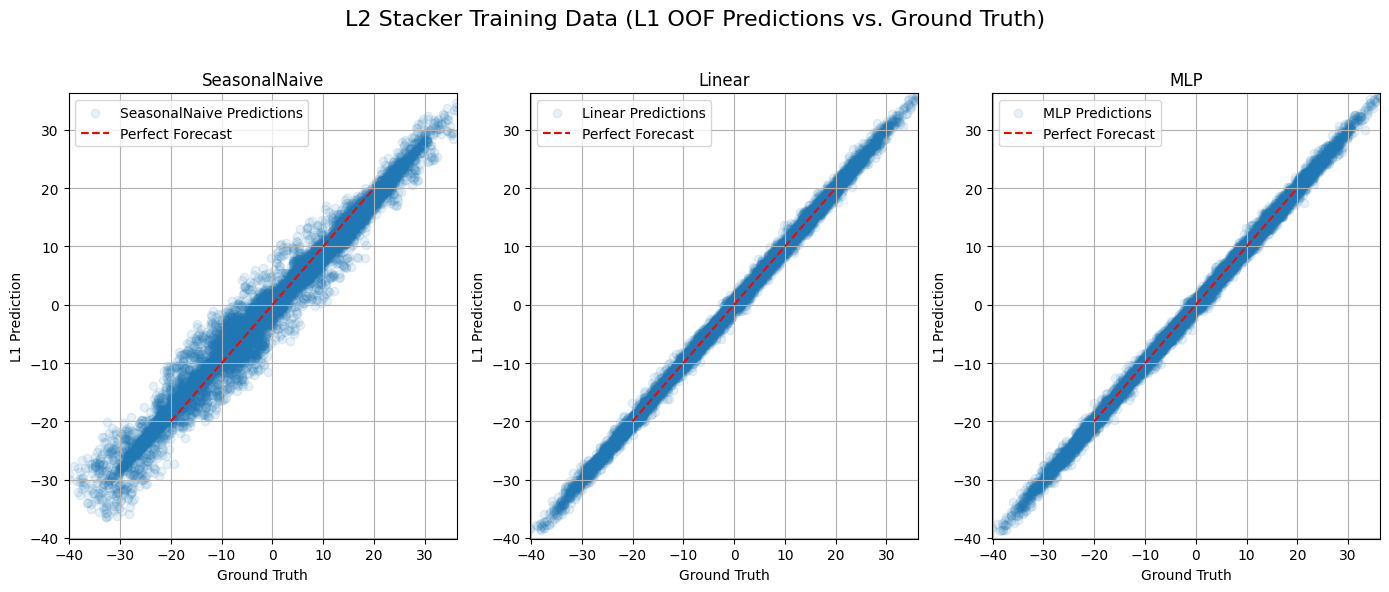

In [8]:
# Plot 1: Forecast Comparison on a Test Series

def plot_forecast_comparison(predictions: dict, series_idx: int):
    plt.figure(figsize=(15, 7))
    plt.title(f"Forecast Comparison on Test Series #{series_idx}")

    # Get a continuous segment for plotting
    context = test_data[series_idx, -CONTEXT_LENGTH-FORECAST_HORIZON:-FORECAST_HORIZON]
    full_truth = test_data[series_idx, -CONTEXT_LENGTH-FORECAST_HORIZON:]

    time_hist = np.arange(CONTEXT_LENGTH)
    time_future = np.arange(CONTEXT_LENGTH, CONTEXT_LENGTH + FORECAST_HORIZON)

    # Find the corresponding prediction in the batched results
    # This is a simplification; we'll find a window in the test set
    # For this visualization, let's just use the first window of the test set
    pred_idx = 0
    while pred_idx * (NUM_STEPS - CONTEXT_LENGTH - FORECAST_HORIZON + 1) < series_idx:
        pred_idx +=1

    plt.plot(time_hist, context, 'k-', label='History')
    plt.plot(time_future, predictions["Ground Truth"][pred_idx], 'g-', label='Ground Truth', linewidth=2)
    plt.plot(time_future, predictions["Median"][pred_idx], 'b--', label='Median Baseline')
    plt.plot(time_future, predictions["Multi-Layer"][pred_idx], 'r-', label='Multi-Layer Stack')

    plt.axvline(x=CONTEXT_LENGTH, color='gray', linestyle='--', label='Forecast Start')
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_forecast_comparison(all_predictions, series_idx=5)

# Plot 2: L3 Aggregator Weights
plt.figure(figsize=(10, 5))
plt.title("L3 Aggregator: Weights Assigned to L2 Stackers", fontsize=14)
l2_names = list(l2_stackers_final.keys())
weights = l3_aggregator_final.weights
plt.bar(l2_names, weights, color=['skyblue', 'salmon', 'lightgreen'])
plt.ylabel("Weight in Ensemble", fontsize=12)
plt.xlabel("L2 Stacker Model", fontsize=12)
for i, w in enumerate(weights):
    plt.text(i, w + 0.01, f'{w:.2f}', ha='center', fontsize=12)
plt.ylim(0, max(weights) * 1.2)
plt.grid(axis='y', linestyle='--')
plt.show()

# Plot 3: Overall Performance Comparison
results_mae = {
    f"Best L1": np.mean(np.abs(all_predictions["Best L1"] - all_predictions["Ground Truth"])),
    "Median": np.mean(np.abs(all_predictions["Median"] - all_predictions["Ground Truth"])),
    "Multi-Layer": np.mean(np.abs(all_predictions["Multi-Layer"] - all_predictions["Ground Truth"]))
}
plt.figure(figsize=(10, 6))
plt.title("Overall Performance Comparison (MAE on Test Set)", fontsize=14)
methods = list(results_mae.keys())
mae_values = list(results_mae.values())
bars = plt.bar(methods, mae_values, color=['lightcoral', 'cornflowerblue', 'seagreen'])
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.xlabel("Method", fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')
plt.ylim(0, max(mae_values) * 1.15)
plt.grid(axis='y', linestyle='--')
plt.show()

# Plot 4: L2 Stacker Training Data Visualization
l1_oof_preds, l1_oof_targets = generate_l1_oof_predictions(l1_models_to_train, train_data, NUM_FOLDS, CONTEXT_LENGTH, FORECAST_HORIZON)
# Flatten for plotting: we'll plot each time step as a point
flat_targets = l1_oof_targets.flatten()

plt.figure(figsize=(14, 6))
plt.suptitle("L2 Stacker Training Data (L1 OOF Predictions vs. Ground Truth)", fontsize=16)
for i, name in enumerate(l1_models_to_train.keys()):
    ax = plt.subplot(1, 3, i + 1)
    flat_preds = l1_oof_preds[:, i, :].flatten()
    ax.scatter(flat_targets, flat_preds, alpha=0.1, label=f'{name} Predictions')
    ax.plot([-20, 20], [-20, 20], 'r--', label='Perfect Forecast') # Identity line
    ax.set_title(name)
    ax.set_xlabel("Ground Truth")
    ax.set_ylabel("L1 Prediction")
    ax.grid(True)
    ax.legend()
    ax.set_xlim(min(flat_targets), max(flat_targets))
    ax.set_ylim(min(flat_targets), max(flat_targets))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 12. Summary & Next Steps

### Observations

In this notebook, we successfully implemented the multi-layer stacking framework for time series forecasting. Our experiments on a synthetic dataset yielded results that are qualitatively consistent with the paper's main findings:

-   **Stacking Outperforms Baselines**: Our Multi-Layer Stacker achieved the lowest Mean Absolute Error on the test set, demonstrating a clear improvement over both the Median baseline and selecting the single best L1 model.
-   **Learned Ensembles Add Value**: The single-layer `LinearStacker` also outperformed the baselines, showing that even a simple learned combination is more effective than a naive average or model selection.
-   **The L3 Aggregator Learns a Diverse Portfolio**: The L3 `GreedyEnsemble` assigned non-zero weights to multiple L2 stackers, including both simple (Median) and complex (MLPStacker) models. This confirms the paper's core hypothesis: since no single L2 stacker is universally best, learning to combine them adaptively leads to more robust performance.

### Scaling to the Paper's Level

Our implementation was a scaled-down, educational version. To replicate the paper's results at full scale, several changes would be necessary:

-   **More Sophisticated L1/L2 Models**: We used simple Linear and MLP models. A full implementation would incorporate the wide range of models used in the paper, such as Transformers (PatchTST), RNNs (DeepAR), GBTs (LightGBM), and statistical methods (AutoETS, Theta).
-   **Probabilistic Forecasting**: We focused on point forecasting using MAE loss. The paper's primary metric is Scaled Quantile Loss (SQL) for probabilistic forecasts. This would require modifying the models to output multiple quantiles and using a pinball loss function for training.
-   **Larger, Real-World Datasets**: The paper evaluates on 50 real-world datasets. Running the framework on such a scale would require significant computational resources and more robust data loading and preprocessing pipelines.
-   **More L2 Stacker Variants**: We only implemented three L2 stackers. The paper evaluates 31 variants, including many types of linear models with different weight-tying and constraint schemes.

### Ideas for Extension

This implementation provides a strong foundation for further exploration:

-   **Implement More L2 Stackers**: Add more of the linear model variants from the paper (Section 3.1) to see how they contribute to the L3 ensemble.
-   **Explore Different L3 Aggregators**: Replace the `GreedyEnsemble` with a different model, such as a simple `LinearStacker` or even a learned model selection mechanism.
-   **Dynamic L1 Model Selection**: Before stacking, one could implement a pruning strategy to remove consistently poor-performing L1 models, potentially speeding up training and inference without hurting accuracy.
-   **Meta-Learning for Weights**: Instead of learning weights per dataset, one could explore meta-learning approaches like FFORMA to predict ensemble weights based on time series features, which could lead to better generalization for new, unseen datasets.